### Imports

In [1]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Tensorflow
from tensorflow import keras

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

2023-07-11 19:48:24.977428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [135]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [3]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File - EDA

In [4]:
#loading csv file

df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Viewing columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Renaming column for easier callback/reference

df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [7]:
#Viewing change 

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
#checking NaN values in columns

df.isna().sum()

tweet_text                            1
emotion_in_tweet_is_directed_at    5802
emotion                               0
dtype: int64

In [9]:
# Dropping column as it is not needed for sentiment analysis

df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [10]:
# Dropping NaN values in the df
df.dropna(axis = 0, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   emotion     9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [12]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [13]:
# Dropping values that contain no emotion; Keeping only positive and negative emotions
df2 = df[df['emotion'] != "I can't tell"]
df2 = df2[df2['emotion'] != "No emotion toward brand or product"]

In [14]:
df2['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [15]:
# Creating emotion column into a numerical value
df2['target'] = df2['emotion'].astype('category')
categories = ['Positive emotion', 'Negative emotion']
df2['target'] = df2['target'].cat.reorder_categories(categories)
df2['target'] = df2['target'].cat.codes
df2['target'].value_counts()

0    2978
1     570
Name: target, dtype: int64

In [16]:
# Viewing 1st tweet in the df 
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

<Axes: xlabel='emotion', ylabel='count'>

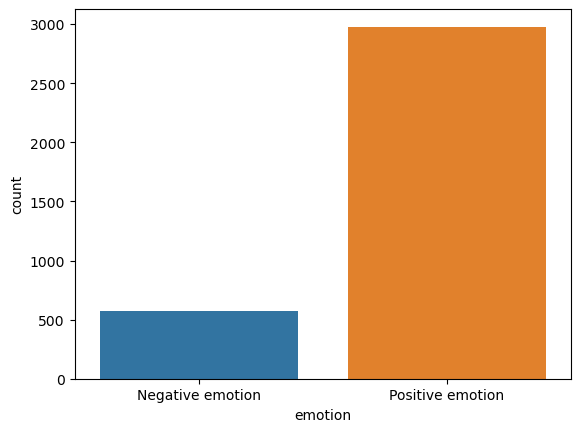

In [18]:
#Visualization of data distribution
sns.countplot(x = 'emotion', data = df2)

### Text PreProcessing 

In [19]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", 
                         tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # rejoining lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [21]:
df2['tweet_text'] = df2['tweet_text'].apply(process_tweet, args = [10])
df2

,tweet_text,emotion,target
0,iphone hr tweet dead need upgrade plugin station,Negative emotion,1
1,know awesome app likely appreciate design also...,Positive emotion,0
2,wait also sale,Positive emotion,0
3,hope year festival crashy year iphone app,Negative emotion,1
4,great stuff fri mayer google tim tech amp matt...,Positive emotion,0
...,...,...,...
9077,pr guy convince switch back iphone great coverage,Positive emotion,0
9079,quot papyrus sort ipad quot nice lol lavelle,Positive emotion,0
9080,diller say google tv quot run playstation xbox...,Negative emotion,1
9085,always use iphone image stabilizer mode sugges...,Positive emotion,0


### Vectorizing

In [23]:
X = df2['tweet_text']
y = df2['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [26]:
tf_vec = TfidfVectorizer()
vec = tf_vec.fit(X_train)
vec

TfidfVectorizer()

In [27]:
len(vec.get_feature_names_out())

3579

In [28]:
X_tr_vec = vec.transform(X_train)
X_te_vec = vec.transform(X_test)

In [29]:
#Topic Modeling

In [30]:
top_mod = NMF(n_components = 2)
top_mod.fit(X_tr_vec)

NMF(n_components=2)

In [31]:
H = top_mod.transform(X_tr_vec)
W = top_mod.components_

print("Shape of W is" + str(W.shape))
print("Shape of H is" + str(H.shape))
print("Shape of train is" + str(X_tr_vec.shape))

Shape of W is(2, 3579)
Shape of H is(2838, 2)
Shape of train is(2838, 3579)


In [32]:
# 2,838 tweets in this train set
# 3,579 features

In [56]:
vec_df = pd.DataFrame(X_tr_vec.toarray(), columns = vec.get_feature_names_out())
vec_df['target'] = y_train
vec_df

,aapl,abacus,ability,able,abroad,absolutely,abt,abuzz,acc,acceptable,...,zappos,zazzle,ze,zeldman,zms,zomg,zone,zoom,zzzs,åç
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
vec_df['target'].value_counts()

0.0    787
1.0    143
Name: target, dtype: int64

In [58]:
vec_df.iloc[200].sort_values(ascending = False)[:10]

cluttering    0.363386
handset       0.363386
planet        0.350073
lonely        0.339747
enough        0.317997
city          0.312546
guide         0.271184
release       0.245892
apps          0.209739
free          0.208096
Name: 200, dtype: float64

In [59]:
# Tweet Classifier Model

In [60]:
#Target Fraction
priors = y_train.value_counts()/y_train.shape[0]
priors

0    0.8358
1    0.1642
Name: target, dtype: float64

In [62]:
#Class 1 Probability

Pos = vec_df[vec_df['target'] == 1].drop(columns = ['target'])

N_tok = Pos.sum(axis = 0)
N1 = Pos.values.sum()

prob_pos = N_tok/N1

prob_pos.sort_values(ascending = False)[0:10]

link      0.020891
apple     0.017213
new       0.015954
ipad      0.015636
rt        0.014988
google    0.014360
store     0.013628
iphone    0.011490
get       0.010885
quot      0.010338
dtype: float64

In [68]:
#Class 2 Probability

Neg = vec_df[vec_df['target'] == 0].drop(columns = ['target'])

N_tok2 = Neg.sum(axis = 0)
N2 = Neg.values.sum()

prob_neg = N_tok2/N2

prob_neg.sort_values(ascending= False)[0:10]

link      0.020226
ipad      0.016937
rt        0.015927
apple     0.013815
store     0.011979
google    0.011720
iphone    0.011606
quot      0.010510
app       0.010110
get       0.006993
dtype: float64

In [93]:
#Model Eval



In [122]:
def model_eval(model):
    
    y_pred = model.predict(X_te_vec)
    
    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    categories = ['Negative', 'Postive']
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    group_percentages = ['{0:2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds', fmt = '',
                xticklabels = categories, yticklabels = categories)
    
    plt.xlabel('Predicted Values', fontdict = {'size':14}, labelpad = 10)
    plt.ylabel('Actual Values', fontdict = {'size':14}, labelpad = 10)
    plt.title('Confusion Matrix', fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       606
           1       0.83      0.14      0.25       104

    accuracy                           0.87       710
   macro avg       0.85      0.57      0.59       710
weighted avg       0.87      0.87      0.83       710



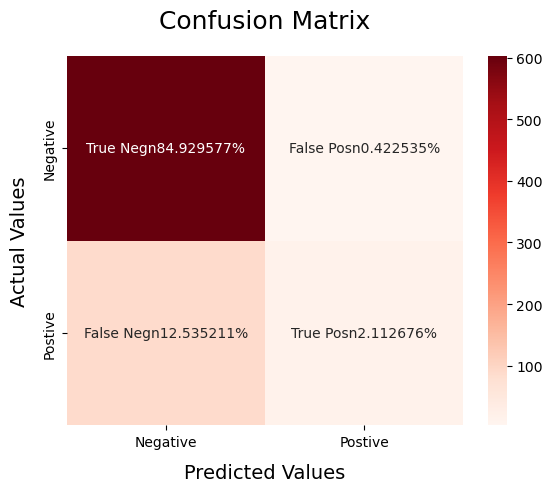

In [123]:
# Bernoulli model 
BN_Model = BernoulliNB()
BN_Model.fit(X_tr_vec, y_train)
model_eval(BN_Model)
BN_pred = BN_Model.predict(X_te_vec)

In [130]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5)
rf.fit(X_tr_vec, y_train)

RandomForestClassifier(max_depth=5)

In [132]:
print(rf.score(X_tr_vec, y_train))
print(rf.score(X_te_vec, y_test))

0.835799859055673
0.8535211267605634


In [133]:
rf_pred = rf.predict(X_te_vec)

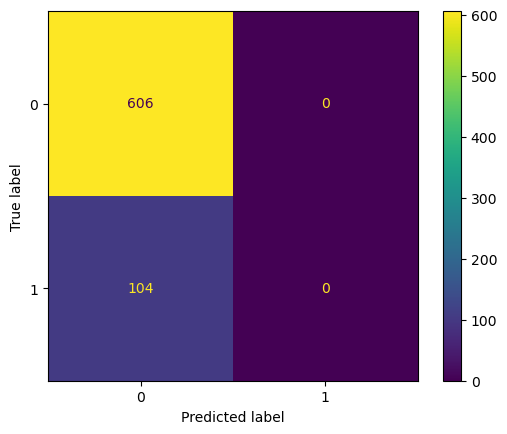

In [137]:
rf_cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_cm).plot()

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       606
           1       0.00      0.00      0.00       104

    accuracy                           0.85       710
   macro avg       0.43      0.50      0.46       710
weighted avg       0.73      0.85      0.79       710



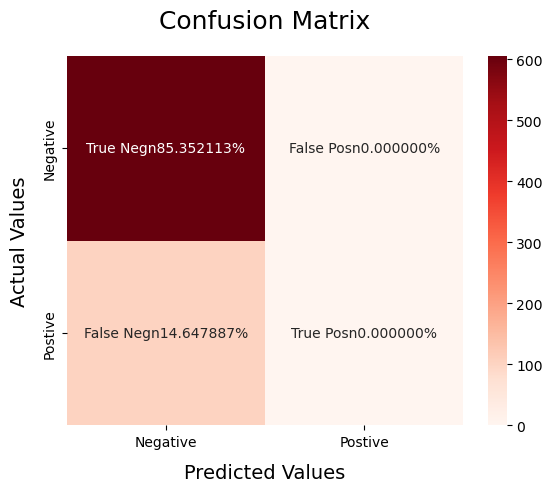

In [138]:
model_eval(rf)